# Introdução

Usamos o dataset sugerido dos raio-x de pacientes com ou sem pneumonia. Classificação binária, fácil de diferenciar.

# Estratégia

Carregamos o dataset e fizemos diversas transformações com `ImageDataGenerator` imagem por imagem, para que o modelo generalizasse bem imagens transformadas ou parecidas.

# Artigos úteis

- [1] https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918
- [2] https://rohan09.medium.com/building-and-using-a-convolutional-neural-network-cnn-for-image-classification-with-keras-and-7abf571f0abb

In [19]:
import os  # Diretórios
import numpy as np # Não usei
import matplotlib.pyplot as plt # Plotação
import tensorflow as tf # Importação pra evitar erros com o keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Carrega imagens dinamicamente da pasta e gera imagens transformadas diversas para o modelo generalizar melhor
from tensorflow.keras.applications import VGG16 # CNN pré-treinada da imagenet. Transfiro o aprendizado e adiciono camadas novas pro problema do raio-x.
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D # Camadas.
from tensorflow.keras.models import Model # Construção do modelo..
from tensorflow.keras.optimizers import Adam # Otimizador que altera a taxa de aprendizado (pesos) no treino
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix # Métricas pedidas no trabalho

## Diretórios

- train_dir é o diretório das imagens usadas pro treino
- val_dir é o diretório das imagens inéditas (8 por classe) pra avaliar o desempenho no treino
- test_dir é o diretório de imagens inéditas pra testar a precisão do modelo pós-treino.

In [20]:
base_dir = 'chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

## Parâmetros do modelo

O VGG16 recebe imagens de 224x224 pixels, então adotei esse valor.
O tamanho do batch é o num. de imagens processadas em cada iteração durante o treino. Escolhi 32 por ser um valor comum no stackoverflow que o pessoal adota.

In [21]:
img_width, img_height = 224, 224
batch_size = 32

## Geradores de imagens

Guardo configs de transformação futura na classe ImageDataGenerator para usar no flow_from_directory. Nela faço normalização, transformação, escala, rotação da imagem, e até flip horizontal assim que carrego as fotos no dataset. Ou seka. diversas imagens a partir de uma são criadas e guardadas no train_generator/val_generator/test_generator.

Eu não faço alterações drásticas nas imagens do dataset validação e teste pois são cenários reais sem variação forçada.

In [22]:
# Criação dos ImageDataGenerators para treino, validação e teste
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#####

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=1,      # Para avaliação, processamos uma imagem por vez
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Amostragem

Ploto as imagens mostrando exemplos raio-x de pessoas com e sem pneumonia após carregamento no dataset.

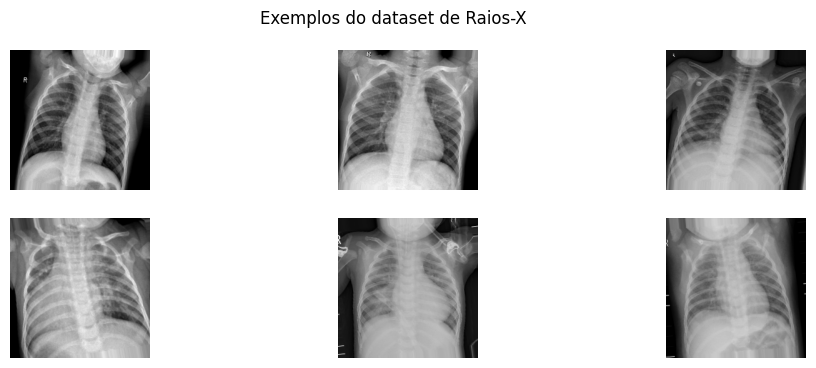

In [23]:
# Exibição de alguns exemplos do dataset
import random
sample_imgs, _ = next(train_generator)
plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_imgs[i])
    plt.axis('off')
plt.suptitle("Exemplos do dataset de Raios-X")
plt.show()

## VGG16 (modelo de visão computacional)

O artigo original do Simonyan e Zisserman de 2014 não diz quanto tempo levou o treino, mas provavelmente levou semanas com diversas GPU Nvidia Titan.

É capaz de classificar 1000 imagens de 1000 diferentes categorias com 92.7% de acurácia [1]. Popular, fácil de usar e fácil de transferir aprendizado.

`include_top` está falso porque precisamos das últimas camadas para treinar o modelo de classificar pneumonia. Colocar falso exclui as últimas camadas originais.

O loop garante que os pesos do VGG16 não vão ser atualizados no treinamento a cada camada. Isso garante que o modelo não vai perder o aprendizado original durante o treino visando os raio-x.

In [ ]:
# Construção da arquitetura utilizando transferência de aprendizado com VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# Congela as camadas do VGG16
for layer in base_model.layers:
    layer.trainable = False

## Criação das camadas

Pego a saída do modelo VGG16 `base_model.output` e vou adicionando camadas minhas a partir dele.


### GlobalAveragePooling2D

Aparenta ser melhor que o Flatten. Pelo que estudei, reduz muito mais parâmetros, menos risco de overfitting e mantém informações essenciais.

### Dense

Conecta os neurônios da camada anterior aos neurônios da camada seguinte. Essa camada é usada em classificação, regressão e aprendizado profundo. Aplica uma transformação linear na entrada e adiciona uma função de ativação.

| Ativação | Fórmula | Uso Comum |
|----------|--------|-----------|
| `relu` | $ \max(0, x) $ | Camadas ocultas |
| `sigmoid` | $\frac{1}{1+e^{-x}}$ | Saída para classificação binária |
| `softmax` | $\frac{e^{x_i}}{\sum e^{x_j}}$ | Saída para classificação multiclasse |
| `tanh` | $\frac{e^x - e^{-x}}{e^x + e^{-x}}$ | Alternativa ao ReLU |

### Dropout

Desativa aleatoriamente neurônios de uma camada com uma probabilidade $p$. Ajuda a reduzir o overfitting. Isso significa que esses neurônios não participam da forward pass nem da backpropagation naquele passo.

- Se tiver uma camada `Dense(128)` e aplicar `Dropout(0.5)`, metade dos neurônios vão ser desligados aleatoriamente em cada atualização dos pesos.
- Durante a inferência (teste), todos os neurônios são utilizados normalmente, mas com os pesos ajustados para compensar a falta de neurônios durante o treino.

### Camada 4

Camada final com 1 neurônio e ativação sigmoide, que gera uma saída entre 0 e 1 para classificação binária (pneumonia ou não).

In [25]:
# Adiciona camadas customizadas para a classificação binária
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # saída para classificação binária

## Construção final do modelo

Constrói o modelo final unindo a base pré-treinada (VGG16) com as camadas que eu defini.

### model.compile(...):

Configura o modelo para o treinamento:

- `optimizer=Adam(learning_rate=0.0001)`: Utiliza o otimizador Adam com uma taxa de aprendizado de 0.0001
- `loss='binary_crossentropy'`: Usado pra classificação binária
- `metrics=['accuracy']`: Monitora a acurácia durante o treinamento.

No final exibe um resumo da arquitetura do modelo, incluindo a quantidade de parâmetros treináveis e não treináveis.

In [26]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Treinamento do modelo

Definimos o número de épocas, que são as iterações completas sobre o conjunto de treino para 20. Achamos esse valor o mais adequado sem causar muito overfitting.

`model.fit()` inicia o treinamento, com os dados de treino, quantos batches vão ser processados por ´epoca, defino os dados de validação, quantos batches de validação vão ser processados por época, e o número de épocas. 

In [27]:
# Treinamento do modelo
epochs = 6
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=epochs,
)


Epoch 1/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - accuracy: 0.6913 - loss: 0.5965 - val_accuracy: 0.5000 - val_loss: 0.7693
Epoch 2/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.7869 - loss: 0.4305 - val_accuracy: 0.5625 - val_loss: 0.7176
Epoch 3/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.8427 - loss: 0.3590 - val_accuracy: 0.5625 - val_loss: 0.7228
Epoch 4/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.8691 - loss: 0.3082 - val_accuracy: 0.6875 - val_loss: 0.6411
Epoch 5/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.8863 - loss: 0.2811 - val_accuracy: 0.6875 - val_loss: 0.6039
Epoch 6/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.8995 - loss: 0.2582 - val_accuracy: 0.6875 - val_loss: 0.6620


In [28]:
# Salvando o modelo nos formatos HDF5 e no formato keras (SavedModel)
model.save('modelo_pneumonia.h5')
model.save('modelo_pneumonia.keras')

## Plot

Plotagem da acurácia de treino e validação, e erro de treino e validação

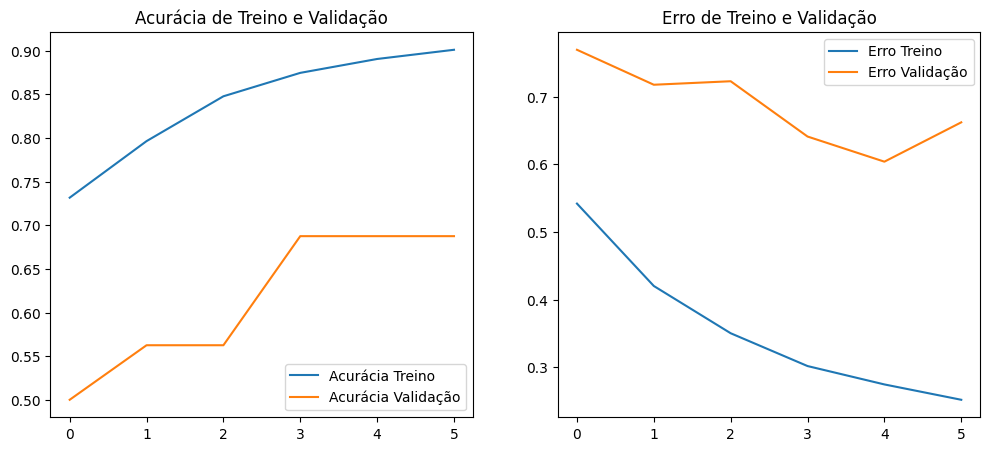

In [29]:
# Plotando as curvas de treinamento e validação
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia Treino')
plt.plot(epochs_range, val_acc, label='Acurácia Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino e Validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Erro Treino')
plt.plot(epochs_range, val_loss, label='Erro Validação')
plt.legend(loc='upper right')
plt.title('Erro de Treino e Validação')
plt.show()

## Avaliação 

- `test_generator.reset()` garante que o gerador de teste comece desde o início, especialmente se ele já foi usado antes.
- `model.predict(...)` Realiza predições para todas as imagens do conjunto de teste. `steps=test_generator.samples` Processa todas as amostras uma vez (batch size 1).
- `classification_report` Gera relatório detalhado com métricas como precisão, recall, F1-score e acurácia para cada classe, conforme pedido no trabalho.

In [30]:
# Avaliação do modelo no conjunto de teste
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples)
# Como usamos ativação sigmoide, limiaramos a probabilidade em 0.5
predicted_classes = (predictions > 0.5).astype(int)

# Extraindo as classes reais
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Imprime o relatório de classificação
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Relatório de Classificação:\n", report)

624/624 ━━━━━━━━━━━━━━━━━━━━ 89s 143ms/step
Relatório de Classificação:
               precision    recall  f1-score   support

      NORMAL       0.92      0.59      0.72       234
   PNEUMONIA       0.80      0.97      0.88       390

    accuracy                           0.83       624
   macro avg       0.86      0.78      0.80       624
weighted avg       0.84      0.83      0.82       624



## Análise do Gráfico

### Acurácia de Treino (azul) 

Sobe de~0.69 na primeira época até quase 0.90 no final. Bom crescimento, mostra que o modelo tá aprendendo com o conjunto de treinamento, talvez devido ao dataset ser grande.

### Acurácia de Validação (laranja)

Começa em torno de 0.50 e depois flutua, sobe para mais ou menos 0.68, que não é ruim, mas é muito menor do que a acurácia de treino 0.90.

Como são só 16 imagens na validação a curva laranja tem saltos.

### Erro de Treino (azul)

O erro de treino cai, perfeitamente normal durante o treino e aumento da acurácia..

### Erro de Validação (laranja)

Oscila e permanece relativamente alto comparado com o erro de treino.

### Conclusão

A amostra de validação é baixa, e isso não ajuda a mostrar a performance. O modelo tá treinando em um dataset decente ( 5000 imagens), mas valida em 16 imagens apenas.

## Resultado do relatório de classificação

Dado o relatório

Relatório de Classificação:
|        -        |precision |  recall  | f1-score | support |
|-----------------|----------|----------|----------|---------|
|     cracked     |   0.92   |   0.59   |   0.72   |   234   |
|      normal     |   0.80   |   0.97   |   0.88   |   390   |
|    accuracy     |    -     |    -     |   0.83   |   624   |
|   macro avg     |   0.86   |   0.78   |   0.80   |   624   |
|  weighted avg   |   0.84   |   0.83   |   0.82   |   624   |


O modelo raramente erra quando fala “normal” (92% de precisão), mas deixa passar 41% dos normais como pneumonia (pois o recall  é de 59%).

No caso da pneumonia, o modelo quase não perde nenhum caso (97% de recall), mas às vezes chama normal de pneumonia (80% de precisão).

No geral, 83% das imagens do teste foram classificadas certas.

## Extra: Precisão e Recall

As métricas são um pouco confusas, mas a seguir fiz uma explicação de como funcionam na prática.

#### O Que o Modelo Faz Quando Vê Uma Imagem?
Ele precisa **escolher entre duas opções**:  
✅ **"Esse raio-X mostra um pulmão com pneumonia"**  
❌ **"Esse raio-X mostra um pulmão normal"**  

Seja um exemplo com 200 raio-x para teste, 100 com e 100 sem pneumonia.

Passo esses 200 raio-x para o modelo. De acordo com as métricas, o que aconteceu é:


| **Imagem Real**  | **Modelo Previu**  | **Certo/Errado?** |
|-----------------|-----------------|---------------|
| Pneumonia ✅ | Pneumonia ✅ | ✅ Acertou! |
| Pneumonia ✅ | Pneumonia ✅ | ✅ Acertou! |
| Pneumonia ✅ | Pneumonia ✅ | ✅ Acertou! |
| Pneumonia ✅ | Pneumonia ✅ | ✅ Acertou! |
| Pneumonia ✅ | Normal ❌ | ❌ Errou! (não detectou a pneumonia) |
| Pneumonia ✅ | Normal ❌ | ❌ Errou! |
| Pneumonia ✅ | Normal ❌ | ❌ Errou! |
| Pneumonia ✅ | Normal ❌ | ❌ Errou! |
| Pneumonia ✅ | Normal ❌ | ❌ Errou! |
| Pneumonia ✅ | Normal ❌ | ❌ Errou! |
| ... | ... | ... |
| **TOTAL de pacientes com pneumonia (100)** | **O modelo previu 59 corretamente e errou 41!** | |

Agora os **100 pacientes normais**:

| **Imagem Real**  | **Modelo Previu**  | **Certo/Errado?** |
|-----------------|-----------------|---------------|
| Normal ✅ | Normal ✅ | ✅ Acertou! |
| Normal ✅ | Normal ✅ | ✅ Acertou! |
| Normal ✅ | Normal ✅ | ✅ Acertou! |
| Normal ✅ | Normal ✅ | ✅ Acertou! |
| Normal ✅ | Pneumonia ❌ | ❌ Errou! (chamou um normal de pneumonia) |
| Normal ✅ | Pneumonia ❌ | ❌ Errou! |
| Normal ✅ | Pneumonia ❌ | ❌ Errou! |
| Normal ✅ | Pneumonia ❌ | ❌ Errou! |
| Normal ✅ | Pneumonia ❌ | ❌ Errou! |
| Normal ✅ | Pneumonia ❌ | ❌ Errou! |
| ... | ... | ... |
| **TOTAL de pacientes normais (100)** | **O modelo previu 97 corretamente e errou 3!** | |

Agora com esses dados se calcula a precisão e recall*.

#### PRECISÃO (PRECISION)
Das **previsões de "pneumonia"**, quantas estavam certas?

- O modelo disse **"pneumonia"** para **74 pacientes** (59 eram pneumonia de verdade + 15 eram normais).  
- Desses 74, **59 estavam corretos**.  

🔹 **Precisão (pneumonia) = 59 acertos / 74 previsões de "pneumonia" = 0.80 (80%)**  
**Ou seja:** Quando o modelo diz "pneumonia", ele está certo em 80% dos casos.  

✅ **Se o modelo disse "pneumonia", pode confiar, mas há uma chance de 20% de que seja um falso alarme.**  

### RECALL
Dos **100 pacientes com pneumonia de verdade**, quantos o modelo detectou?

- O modelo deveria ter detectado **100 casos de pneumonia**.  
- Mas ele só conseguiu detectar **59**.  
- Ele perdeu **41 casos de pneumonia**.

🔹 **Recall (pneumonia) = 59 detectados / 100 reais = 0.59 (59%)**  
**Ou seja:** O modelo deixou passar **41% das pneumonias sem detectar**.  

❌ **Se você mostrar um raio-X de pneumonia para o modelo, ele tem 41% de chance de errar e chamar de normal.**  